![](/images/blog/optimal-bh-fdr-control.png)

Controlling for [false discovery rate (FDR)](https://en.wikipedia.org/wiki/False_discovery_rate) has become a ubiquitous step in statistical analyses that test multiple hypotheses, like those commonly performed in the genomics field. The seminal method for controlling FDR, the [Benjamini-Hochberg (BH-FDR) procedure](https://en.wikipedia.org/wiki/False_discovery_rate#Benjamini%E2%80%93Hochberg_procedure) guarantees FDR control under some simple assumptions, but how does it really perform in the limit of an ideal dataset and ideal statistical test? In this post, we'll dive into this question and reveal that the proportion of truly non-null data points has a major influence on the behavior of BH-FDR.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/gilgi/gilgi.github.com/blob/src/posts/optimal_bh_fdr_control.ipynb)

<!-- TEASER_END -->

In [0]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, confusion_matrix

from lib5c.util.statistics import adjust_pvalues
from hic3defdr.evaluation import compute_fdr
from hic3defdr import plot_fdr
from hic3defdr import plot_roc

In [0]:
np.random.seed(42)

In [0]:
def evaluate(y_true, qvalues):
    y_pred = 1 - qvalues
    fpr, tpr, thresh = roc_curve(y_true, y_pred)
    fdr = np.ones_like(fpr) * np.nan
    for i in range(np.argmax(tpr > 0), len(thresh), max(len(thresh)/100, 1)):
        fdr[i] = compute_fdr(y_true, y_pred >= thresh[i])
    return fdr, fpr, tpr, thresh

In [0]:
def repack(eval_result):
    return dict(zip(['fdr', 'fpr', 'tpr', 'thresh'], eval_result))

We will set up a simple simulation setting that embodies a generic statistical test under "theoretically perfect" conditions.

We will look at some normally distributed data with known and fixed standard deviation $\sigma = 0.5$. We will generate the data points from the model:

$$ x_i \sim \textrm{Normal}(\mu_i, 0.5)$$

where

$$\mu_i = \begin{cases} 
    0 & \textrm{the data point is a true null} \\
    \beta \times \sigma & \textrm{the data point is a true alt}
\end{cases}$$

where $\beta$ is an effect size in units of the standard deviation $\sigma$.

We will set $p_{\textrm{diff}} = 0.4$ of the the $n = 10{,}000$ data points to be true alt, and the rest to be true null.

For each data point, we will test the null hypothesis that the data point was generated from a $\textrm{Normal}(\mu, 0.5)$ distribution with $\mu = 0$ versus the alternative hypothesis of $\mu > 0$.

We will use a $\textrm{Normal}(0, 0.5)$ distribution to call right-tail p-values corresponding to this combination of null and alternative hypotheses.

To control for multiple testing (since we are testing $n = 10{,}000$ points simultaneously), we will use BH FDR to adjust the p-values to q-values. Finally, we will compare the q-values to the true alt labels to obtain ROC and FDR control curves.

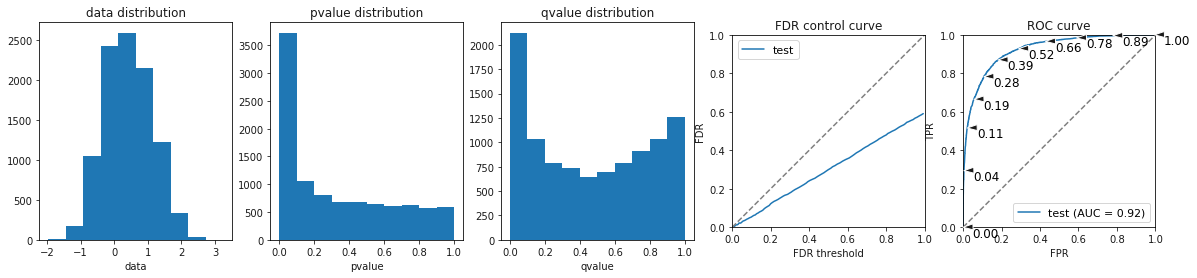

In [0]:
sigma = 0.5
beta = 2.0
p_diff = 0.4
n = 10000

means = np.zeros(n)
y_true = np.random.rand(n) < p_diff
means[y_true] += beta * sigma
data = stats.norm(means, sigma).rvs()
pvalues = stats.norm(0, sigma).sf(data)
qvalues = adjust_pvalues(pvalues)
eval_result = repack(evaluate(y_true, qvalues))

fig, (data_ax, pvalue_ax, qvalue_ax, fdr_ax, roc_ax) = \
    plt.subplots(1, 5, figsize=(20, 4))
data_ax.hist(data)
data_ax.set_xlabel('data')
data_ax.set_title('data distribution')
pvalue_ax.hist(pvalues)
pvalue_ax.set_xlabel('pvalue')
pvalue_ax.set_title('pvalue distribution')
qvalue_ax.hist(qvalues)
qvalue_ax.set_xlabel('qvalue')
qvalue_ax.set_title('qvalue distribution')
plot_fdr([eval_result], ['test'], ax=fdr_ax)
fdr_ax.set_title('FDR control curve')
plot_roc([eval_result], ['test'], ax=roc_ax)
roc_ax.set_title('ROC curve');

Now that we have set up and visualized the simulation setting, we can ask some questions about the limits of the performance of BH FDR in terms of the FDR control curve.

The first question we will ask is how BH FDR control performs as a function of the effect size $\beta$. For example, as the problem gets "easier" (i.e., as the distributions of true null and true alt points become more separated), we might think that the FDR control curve may change. To test this, we will sweep over different values of $\beta$ between 1 and 100 and overlay the resulting FDR control curves:

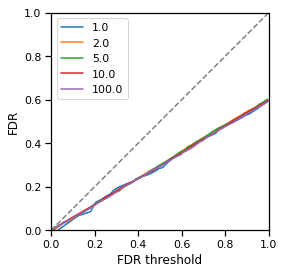

In [0]:
sigma = 0.5
p_diff = 0.4
n = 10000
betas = [1., 2., 5., 10., 100.]
eval_results = []
labels = []
for beta in betas:
    means = np.zeros(n)
    y_true = np.random.rand(n) < p_diff
    means[y_true] += beta * sigma
    data = stats.norm(means, sigma).rvs()
    pvalues = stats.norm(0, sigma).sf(data)
    qvalues = adjust_pvalues(pvalues)
    eval_results.append(repack(evaluate(y_true, qvalues)))
    labels.append(beta)
plot_fdr(eval_results, labels);

It is clear that the FDR control properties of BH FDR do not depend too much on effect size once the problem is "easy enough".

The next question we can ask is how BH FDR control performs as a function of the proportion of true alt data points $p_{\textrm{diff}}$. To test this, we will sweep over different values of $p_{\textrm{diff}}$ between 0.1 and 0.9 (holding $\beta$ fixed at a relatively high value of 10) and overlay the resulting FDR control curves:

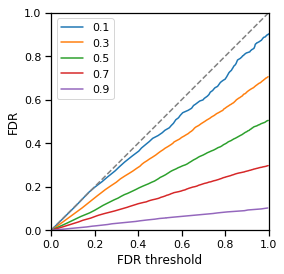

In [0]:
sigma = 0.5
p_diffs = [0.1, 0.3, 0.5, 0.7, 0.9]
n = 10000
beta = 10.
eval_results = []
labels = []
for p_diff in p_diffs:
    means = np.zeros(n)
    y_true = np.random.rand(n) < p_diff
    means[y_true] += beta * sigma
    data = stats.norm(means, sigma).rvs()
    pvalues = stats.norm(0, sigma).sf(data)
    qvalues = adjust_pvalues(pvalues)
    eval_results.append(repack(evaluate(y_true, qvalues)))
    labels.append(p_diff)
plot_fdr(eval_results, labels);

An important thing to note is that these curves reflect the performance characteristics of the exactly the same method on exactly the same "difficulty" of problem (in terms of effect size). It is not the case that the blue curve is the best because it is closeset to the dashed line, instead all curves are performing "optimally" (we have formulated an exact statistical test, the population variance and null population mean are known exactly, etc.) and the only thing that is changing is an attribute of the simuations that is not really related to difficulty ($p_{\textrm{diff}}$).

We observe that the curves all approach an FDR of $1-p_{\textrm{diff}}$ as FDR threshold approaches 1.0. This is because at an FDR threshold of 1.0, all points are called significant, and therefore there are $n$ discoveries and $(1 - p_{\textrm{diff}}) \times n$ of them are false (the remaining $p_{\textrm{diff}} \times n$ are true). The FDR is therefore:

$$\textrm{FDR} = \frac{\textrm{false discoveries}}{\textrm{total discoveries}} = \frac{(1 - p_{\textrm{diff}}) \times n}{n} = 1 - p_{\textrm{diff}}$$

At an FDR threshold of exactly 0.0, the FDR is not defined, since no points are called significant and the denominator of this equation goes to zero. That being said it makes sense that FDR should be asymptotically low when FDR threshold is asymptotically low. This is because at the threshold at which you call just one data point significant (the most significant data point in the entire data set), that single point is very likely to be a true positive. If it is, then your FDR is

$$\textrm{FDR} = \frac{\textrm{false discoveries}}{\textrm{total discoveries}} = \frac{0}{1} = 0$$

We observe that all the curves trace a roughly straight line between $(0.0, 0.0)$ and $(1.0, 1-p_{\textrm{diff}})$. This appears to be a general property of BH FDR control that seems to hold at any effect size $\beta$ and any $p_{\textrm{diff}}$, so long as the problem is "easy enough" in terms of $\beta$.

The fact that these curves stay further below the dashed line at higher $p_{\textrm{diff}}$ suggests that it might be possible for an FDR control method to try to detect the $p_{\textrm{diff}}$ of the dataset (similar to $\pi_0$ in the direct FDR approach) and use this information to "bow" only high-$p_{\textrm{diff}}$ curves upwards a bit while still staying below the dashed line, and therefore presumably gain more poiwer at the "upward bowed" thresholds (by calling more things significant the method is likely to become more powerful). The exploration of this possibility is outside the scope of this document.